# Step I DataSet Information

### 1. Dataset link

The dataset can be  downloaded from the following link

<https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz>


*The dataset is about the amazon reviews of the Gift Card.* 

### 2. Dataset Description
| Dataset Description |    |                                                                                     |
|---------------------|----|-------------------------------------------------------------------------------------|
| marketplace         | -  | 2 letter country code of the marketplace where the review was written.              |
| customer_id         | -  | Random identifier that can be used to aggregate reviews written by a single author. |
| review_id           | -  | The unique ID of the review.                                                        |
| product_id          | -  | The unique Product ID the review pertains to.                                       |
| product_title       | -  | Title of the product.                                                               |
| product_category    | -  | Broad product category that can be used to group reviews                            |
| star_rating         | -  | The 1-5 star rating of the review.                                                  |
| helpful_votes       | -  | Number of helpful votes.                                                            |
| total_votes         | -  | Number of total votes the review received.                                          |
| vine                | -  | Review was written as part of the Vine program.                                     |
| verified_purchase   | -  | The review is on a verified purchase.                                               |
| review_headline     | -  | The title of the review.                                                            |
| review_body         | -  | The review text.                                                                    |
| review_date         | -  | The date the review was written.                                                    |

### 3. DATA FORMAT

Tab ('\t') separated text file, without quote or escape characters.

First line in each file is header; 1 line corresponds to 1 record.

# Step II: Data Ingestion (preprocessing and cleaning)

### 1. To avoid the file to occupy memory space avoid unzipping it: Open and read the dataset with *gzip* library 
### 2. Open the file from the mentioned path in read text mode, providing the encoding format and ignoring the errors that may occur due to zipped format

In [1]:
import gzip
path= 'D:\IBM\\amazon_reviews_us_Gift_Card_v1_00n.tsv.gz'
f= gzip.open(path,'rt',encoding="utf8",errors='ignore')

### 3. Read the csv file with delimiter mentioned in dataset decription. It is tab separated.

In [2]:
import csv
reader= csv.reader(f, delimiter='\t')




### 4. In order to read the file at once use 'next' iterator to read the file's line one by one

__Note__: The first line corresponds to header as mentioned in dataformat.

In [3]:
header= next(reader) 
print(header)

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']


### 5. Below we will:
(a) Read the lines from file in sequential manner.   
(b) Create the dictionary corresponding to attribute: value pair and append it to the dataset list.

In [4]:
dataset=[]

In [5]:
for line in reader:                      # Read the file's line in a sequential manner
    d =dict(zip(header,line))            # Create a dictionary with key corresponding to attributes
    for field in ['star_rating','helpful_votes', 'total_votes']:     # Convert the mentioned fields to "int" datatype
        d[field]=int(d[field])
    for field in ['vine','verified_purchase']: # Convert the mentioned field into  "boolean"
        if d[field]== 'Y':                            
            d[field]= True
        else:
            d[field]=False
    dataset.append(d)                   # Append the dictionary to dataset list

In [6]:
chunk= dataset[0] # Lets call it a chunk
print(chunk)


len_dataset = len(dataset)
print('Dataset contains: '  +str(len_dataset) +' entries.')


{'marketplace': 'US', 'customer_id': '24371595', 'review_id': 'R27ZP1F1CD0C3Y', 'product_id': 'B004LLIL5A', 'product_parent': '346014806', 'product_title': 'Amazon eGift Card - Celebrate', 'product_category': 'Gift Card', 'star_rating': 5, 'helpful_votes': 0, 'total_votes': 0, 'vine': False, 'verified_purchase': True, 'review_headline': 'Five Stars', 'review_body': 'Great birthday gift for a young adult.', 'review_date': '2015-08-31'}
Dataset contains: 148310 entries.


# Step II: Simple statistics (Exploratory Data Analysis)

### 1. What is  Average star_rating?


#### Method 1

In [7]:
rating_listf= []
for i in range(len(dataset)):
    ratingf= dataset[i]['star_rating']
    rating_listf.append(ratingf)
Avg_starf= sum(rating_listf)/len(rating_listf)
print('Avgerage Star Rating is: ' +  str(Avg_starf))

Avgerage Star Rating is: 4.731333018677096


#### Method 2

In [8]:
rating_list= [chunk['star_rating'] for chunk in dataset] # create a list of rating using list comprehension
Avg_star= sum(rating_list)/len(rating_list)          # Calculate the average by summing up rating list/ length 
print('Avgerage Star Rating is: ' +  str(Avg_star))

Avgerage Star Rating is: 4.731333018677096


### 2. How is the Rating Distributed?

__Note__ : Since we do not know in advance what are the ratings given in dataset, we will proceed with empty rating count dictionary.

We will add the values on the fly:

    if the key already exists : we will increment its value
    
    else we will add the new key and assign '1'
    

#### Method 1

In [9]:
rating_count_dictf={}  

#keys: dataset['start_rating']
#values: Total number corresonding to each start rating

for chunk in dataset:     # As above chunk correspongs to one complete entry of dataset consisting of 12 fields 
    key=chunk['star_rating']
    if key in rating_count_dictf:
        rating_count_dictf[key]=rating_count_dictf[key]+1
    else:
        rating_count_dictf[key]=1
rating_count_dictf

{5: 129029, 1: 4766, 4: 9808, 2: 1560, 3: 3147}

#### Method 2

In [10]:
from collections import defaultdict

rating_count_dict=defaultdict(int)

for chunk in dataset:
    key= chunk['star_rating']
    rating_count_dict[key]+=1
rating_count_dict

defaultdict(int, {5: 129029, 1: 4766, 4: 9808, 2: 1560, 3: 3147})

### 3.  Can we find the number of Verified Purchaces?

In [11]:
purchase_count_dict=defaultdict(int)

for chunk in dataset:
    key= chunk['verified_purchase']
    purchase_count_dict[key]+=1
purchase_count_dict


defaultdict(int, {True: 135289, False: 13021})

### 4. What are the Most popular products?

__Note__: Since dictionary is unordered, we need to do the following:
1. Create dictionary of product count
2. Convert it into list containing tuple of product id and count
3. Apply sort method

In [12]:
# Create dictionary of product count
product_count_dict=defaultdict(int)

for chunk in dataset:
    key= chunk['product_id']
    product_count_dict[key]+=1
#product_count_dict

In [13]:
#Convert it into list containing tuple of product id and count

product_count_list = [( product_count_dict[key], key) for key in product_count_dict] # Noe value:key combination [Imp for sorting]

#Apply sort method
product_count_list.sort()

# top 10 popular products
print(product_count_list[-10:])


[(2038, 'B004KNWWO0'), (2173, 'B0066AZGD4'), (2630, 'BT00DDC7CE'), (2643, 'B004LLIKY2'), (3407, 'BT00DDC7BK'), (3440, 'BT00CTOUNS'), (4283, 'B00IX1I3G6'), (5034, 'BT00DDVMVQ'), (6037, 'B00A48G0D4'), (28705, 'B004LLIKVU')]


### 5. What are the top rated products

1. To find rating per product => key = 'product_id' , values= 'start_ratings'
2. To find average rating per product => key = 'product_id', values = average(''star_ratings)

In [14]:
ratingsPerProduct =defaultdict(list)

for chunk in dataset:
    key= chunk['product_id']
    value=chunk['star_rating']
    ratingsPerProduct[key].append(value)
#ratingsPerProduct

In [15]:
AvgratingPerProduct=defaultdict(float)
for key in ratingsPerProduct:
    AvgratingPerProduct[key]=sum(ratingsPerProduct[key])/len(ratingsPerProduct[key])
#AvgratingPerProduct

In [16]:
AvgratingPerProduct_List=[(AvgratingPerProduct[key], key) for key in AvgratingPerProduct if len(ratingsPerProduct[key]) > 50]
AvgratingPerProduct_List.sort()
AvgratingPerProduct_List[-10:]

[(4.918918918918919, 'B004KNWX94'),
 (4.919354838709677, 'B00CRQ496G'),
 (4.923076923076923, 'B00PMLDNBA'),
 (4.931034482758621, 'B00CT77E60'),
 (4.936842105263158, 'B004KNWX76'),
 (4.9423076923076925, 'B00SNMPQYC'),
 (4.944444444444445, 'B007V6EWKK'),
 (4.947368421052632, 'B004LLIL5K'),
 (4.955882352941177, 'B00H5BNKYA'),
 (4.966101694915254, 'B00P8N49M4')]

### 6. What is  the ID of Top Active users?

We need to  do the following:
    
1. count the customer ids, by creating dictionary customer count

    key = customer_id

2. Then create  list of customer count
3. Sort the list and find the top 10  active customers

In [17]:
customer_count_dict=defaultdict(int)

for chunk in dataset:
    key= chunk['customer_id']
    customer_count_dict[key]+=1
#customer_count_dict

In [18]:
customer_count_list= [(customer_count_dict[key], key) for key in customer_count_dict ]
customer_count_list.sort()
customer_count_list[-10:]

[(5, '42184434'),
 (5, '45298444'),
 (5, '45359231'),
 (5, '50442527'),
 (5, '50822336'),
 (5, '51046621'),
 (5, '5572588'),
 (6, '30058414'),
 (6, '52166758'),
 (7, '9374792')]

### 5. What is the average rating  of verified and non-verified purchases?

1. To find rating per verified/non-verified product => key = 'verified_purchase' , values= 'start_ratings'
2. To find average rating per verified/non-verified product => key = 'verified_purchase', values = average(''star_ratings)

In [19]:
Verified_ratingsPerProduct =defaultdict(list)

for chunk in dataset:
    key= chunk['verified_purchase']
    value=chunk['star_rating']
    Verified_ratingsPerProduct[key].append(value)
#Verified_ratingsPerProduct


In [20]:
Verified_AvgratingPerProduct=defaultdict(float)
for key in Verified_ratingsPerProduct:
    Verified_AvgratingPerProduct[key]=sum(Verified_ratingsPerProduct[key])/len(Verified_ratingsPerProduct[key])
#Verified_AvgratingPerProduct

print('Average rating for verified purchaces is: ' + str (Verified_AvgratingPerProduct[True]) + ' and for non-verified purchaces is: '  +
    str (Verified_AvgratingPerProduct[False]) )

Average rating for verified purchaces is: 4.746076916822506 and for non-verified purchaces is: 4.578142999769603


# Step III: Data preprocessing and Cleaning (if we want to work with dates and reject old reviews based on that)

__Task__:  To filter out the older review:
1. Find out if any the review date is missing
2. Filter out the missing value
3. Covert the year into integer: 'review_date': '2004-10-14'

   To do so pick up first fout characters: '2004' and convert into int
4. Then filter out the old reviwes let us say before 2010

In [21]:
count=0
for chunk in dataset:
    if 'review_date' in chunk:
        count+=1
count

148309

*From the output it is clear one of the review date is missing. Lets filter it out that entry and create a new dataset.*


In [22]:
dataset= [chunk for chunk in dataset if'review_date' in chunk]
len(dataset)

148309

In [23]:
chunk['review_date']

'2004-10-14'

In [24]:
for chunk in dataset:
    chunk['yearInt'] = int(chunk['review_date'][:4])

In [25]:
dataset= [chunk for chunk in dataset if chunk['yearInt'] > 2009]
len(dataset)

148095

# Step IV: Data Visualizations

1. On which day of the week the people give the highest rating?

   May be on Friday because they are in happy mood due to weekend. Lets try to find out.

In [26]:
import time
WeekRatings= defaultdict(list)
for chunk in dataset:
    chunk['timeStruct']=time.strptime(chunk['review_date'], '%Y-%m-%d')
    weekday= chunk['timeStruct'].tm_wday
    WeekRatings[weekday].append(chunk['star_rating'])
#WeekRatings
    

In [27]:
Weekrating_Average=defaultdict(int)
for key in WeekRatings:
    Weekrating_Average[key]=sum(WeekRatings[key])/len(WeekRatings[key])
Weekrating_Average

defaultdict(int,
            {0: 4.729210178594263,
             6: 4.734280532043531,
             5: 4.754074575615418,
             4: 4.735956354893893,
             3: 4.718771912250826,
             2: 4.725917760950829,
             1: 4.730875831485587})

In [28]:
X = list(Weekrating_Average.keys())
print(X)
X.sort()
print(X)

Y= [ Weekrating_Average[key] for key in X]
Y

[0, 6, 5, 4, 3, 2, 1]
[0, 1, 2, 3, 4, 5, 6]


[4.729210178594263,
 4.730875831485587,
 4.725917760950829,
 4.718771912250826,
 4.735956354893893,
 4.754074575615418,
 4.734280532043531]

### 1. Line Plot

([<matplotlib.axis.XTick at 0x14b0cbb82e8>,
 <a list of 7 Text xticklabel objects>)

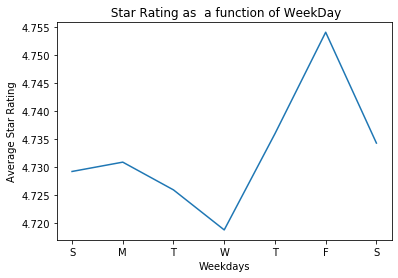

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(X, Y)
plt.xlabel('Weekdays')
plt.ylabel('Average Star Rating')
plt.title(' Star Rating as  a function of WeekDay')
plt.xticks(np.arange(7), ('S', 'M', 'T','W', 'T', 'F', 'S'))

From the line chart it is clear, it is Friday.  

Lets have a look at  the bar plot as well to find the weekday when useer provided highest rating

### 2. Bar Plot

([<matplotlib.axis.XTick at 0x14b0cec58d0>,
 <a list of 7 Text xticklabel objects>)

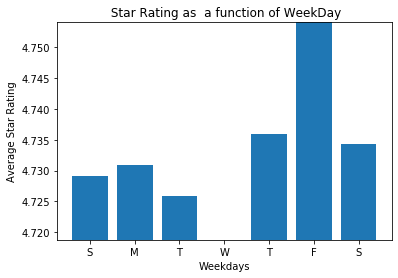

In [30]:
plt.ylim(min(np.array(Y)), max(np.array(Y)))
plt.bar(X, Y)
plt.xlabel('Weekdays')
plt.ylabel('Average Star Rating')
plt.title(' Star Rating as  a function of WeekDay')
plt.xticks(np.arange(7), ('S', 'M', 'T','W', 'T', 'F', 'S'))

# Summary

So this concludes our project.

To summarize, we look at:

1. We looked at  how the Data can be injested without unzipping it.
    
2. We did Exploratory Data Analysis: by looking at the summary statistics and tried to get some insight of the Data.
    
3. We looked at how to work with date and time.
    
4. Finally, with the help of data visualization we ended up on the note that Friday is the good day to receive highest rating. 
       
Thanks :)